# Packages Imports

In [1]:
import os
import random
import json
import cv2

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import tensorflow as tf
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.metrics import MeanIoU, IoU, CategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Model, load_model
from keras.layers import (Input,
                          Activation,
                          MaxPool2D,
                          Concatenate,
                          Conv2D,
                          MaxPooling2D,
                          UpSampling2D,
                          concatenate,
                          Conv2DTranspose,
                          BatchNormalization,
                          Dropout,
                          Lambda)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets Loading

In [2]:
SIZE = (256, 256)
IMG_CHANNELS = 3
N_CLASSES = 2
BATCH_SIZE = 8
input_shape = (*SIZE, IMG_CHANNELS)

TRAIN_PATH = '/content/drive/MyDrive/CoMoFoD/train'

In [3]:
def load_dataset(PATH, images_folder, masks_folder):
    # Load images
    dataset_images = tf.keras.preprocessing.image_dataset_from_directory(
        f"{PATH}/{images_folder}/",
        label_mode=None,  # Use 'label_mode="int"' if you have categorical labels
        image_size=SIZE,  # Resize images to this size (width, height)
        batch_size=BATCH_SIZE,  # Number of images to include in each batch
        shuffle=False,  # Important to maintain corresponding order with masks

    )

    # Load masks
    dataset_masks = tf.keras.preprocessing.image_dataset_from_directory(
        f"{PATH}/{masks_folder}/",
        label_mode=None,
        image_size=SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,  # Important to maintain corresponding order with images
    )

    dataset = tf.data.Dataset.zip((dataset_images, dataset_masks))
    return dataset

In [4]:
# load the dataset
dataset = load_dataset(TRAIN_PATH, "image", "mask").unbatch()
dataset_aug = load_dataset(TRAIN_PATH, "image_aug", "mask_aug").unbatch()

dataset = dataset.concatenate(dataset_aug).shuffle(buffer_size=500)


# Determine the total size of the dataset
dataset_size = sum(1 for _ in dataset)

# Define your split ratio (e.g., 90% for training, 10% for validation)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
dataset_train = dataset.take(train_size).batch(BATCH_SIZE)
dataset_val = dataset.skip(train_size).batch(BATCH_SIZE)

Found 150 files belonging to 1 classes.
Found 150 files belonging to 1 classes.
Found 750 files belonging to 1 classes.
Found 750 files belonging to 1 classes.


In [5]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels
    # will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3)
Labels Batch shape: (8, 256, 256, 3)
Feature shape per sample: (256, 256, 3)
Max Value in Feature: 255.0
Label shape per sample: (256, 256, 3)
Label unique values: [  0.    63.75 127.5  255.   191.25]


In [6]:
def convert_rgb_to_binary(image, mask, threshold=230):
    # Convert RGB to grayscale by taking the mean across the color channels
    grayscale_mask = tf.reduce_mean(mask, axis=-1)

    # Convert grayscale to binary
    binary_mask = tf.where(grayscale_mask > threshold, 1, 0)

    return image, binary_mask

dataset_train = dataset_train.map(convert_rgb_to_binary)
dataset_val = dataset_val.map(convert_rgb_to_binary)

In [7]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3)
Labels Batch shape: (8, 256, 256)
Feature shape per sample: (256, 256, 3)
Max Value in Feature: 255.0
Label shape per sample: (256, 256)
Label unique values: [0 1]


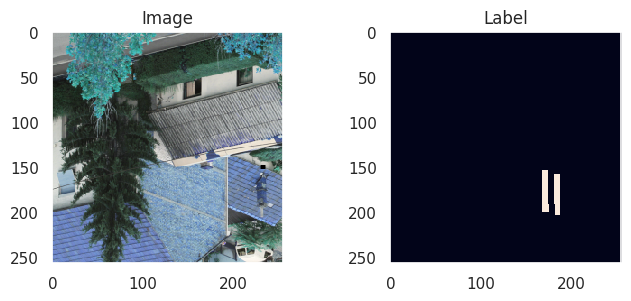

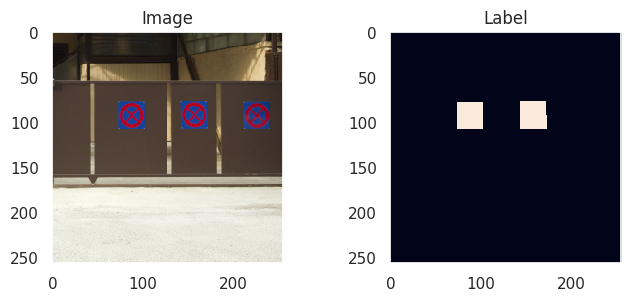

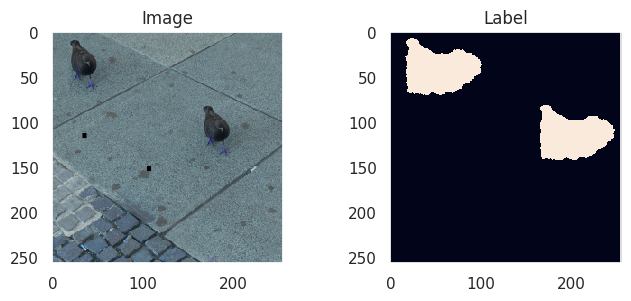

In [8]:
# Looking at samples from the dataset
for images, masks in dataset_train.skip(3).take(3):
    img_number = random.randint(0, images.shape[0] - 1)

    image = images[img_number].numpy().astype("uint8")
    mask = masks[img_number].numpy()

    # Plotting
    _, axs = plt.subplots(1, 2, figsize=(8, 3))

    plots ={
        "Image": image,
        "Label": mask,
    }

    for ax, (name, plot) in zip(axs, plots.items()):
        ax.grid(False)
        ax.set_title(name)
        ax.imshow(plot, interpolation="nearest")

plt.show()

# Labels Preprocessing

Before feeding the data to the model, the labels must be converted to one-hot encoded format. This is need for our model because the labels must be exactly the same as our model's output

In [9]:
# Define a simple mapping function
def preprocess(features, labels):
    # Convert labels to one-hot encoding
    labels = tf.cast(labels, tf.uint8)
    y_cat = tf.one_hot(labels, depth=N_CLASSES)

    features = tf.cast(features, tf.float32) / 255.0
    features = tf.expand_dims(features, axis=-1)

    return features, y_cat

# Apply the mapping function
dataset_train = dataset_train.map(preprocess)
dataset_val = dataset_val.map(preprocess)

In [10]:
print(dataset_train)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>


In [11]:
for features, labels in dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print(f"Batch size: {features.shape[0]}")
    print(f"Features Batch shape: {features.shape}")
    print(f"Labels Batch shape: {labels.shape}")
    print(f"Feature shape per sample: {features.shape[1:]}")
    print(f"Max Value in Feature: {tf.reduce_max(features).numpy()}")
    print(f"Label shape per sample: {labels.shape[1:]}")
    print(f"Label unique values: {tf.unique(tf.reshape(labels[0], [-1])).y.numpy()}")


Batch size: 8
Features Batch shape: (8, 256, 256, 3, 1)
Labels Batch shape: (8, 256, 256, 2)
Feature shape per sample: (256, 256, 3, 1)
Max Value in Feature: 1.0
Label shape per sample: (256, 256, 2)
Label unique values: [1. 0.]


# Model

An original U-Net model is used with an addition of BatchNormalization layer added after every convolution block. This made transfer learning not possible but using our custom model helped to see the effect of these layers and how removing each layer can affect the model's performance

In [41]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x


# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decoder block
# skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    # s3, p3 = encoder_block(p2, 64)
    # s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p2, 128) # Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(b1, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    # Change the activation based on n_classes
    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'
    print(f"Using {activation} function")

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [42]:
model = build_unet(input_shape, n_classes=N_CLASSES)
model.summary()

Using softmax function
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 256, 256, 16)         448       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 256, 256, 16)         64        ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_30 (Activation)  (None, 256, 256, 16)         0         ['b

# Training

The model was trained in cycles of 20 epochs. This was done to overcome some limitation of colab and it disconnecting every now and then.

In [43]:
model.load_weights('/content/drive/MyDrive/cv_data/saved_models/forg_model_ablation.tf')

In [44]:
def lr_scheduler_fn(epoch, lr):
    # LR to be 0.1 * (1/1+0.01*epoch)
    base_lr = 0.01
    factor = 0.001
    return base_lr / (1 + factor * epoch)

In [45]:
IoU_metric = MeanIoU(
    num_classes=N_CLASSES,
    sparse_y_true= False,
    sparse_y_pred=False,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    mode='min',
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_scheduler_fn)


epochs = 20

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy", IoU_metric]
)

In [46]:
history = model.fit(
    dataset_train,
    verbose=1,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[early_stopping],
)

Epoch 1/20
102/102 [==============================] - 24s 126ms/step - loss: 0.0519 - accuracy: 0.9818 - mean_io_u_3: 0.8459 - val_loss: 0.0430 - val_accuracy: 0.9851 - val_mean_io_u_3: 0.8655
Epoch 2/20
102/102 [==============================] - 14s 117ms/step - loss: 0.0513 - accuracy: 0.9819 - mean_io_u_3: 0.8494 - val_loss: 0.0798 - val_accuracy: 0.9757 - val_mean_io_u_3: 0.7688
Epoch 3/20
102/102 [==============================] - 14s 115ms/step - loss: 0.0504 - accuracy: 0.9823 - mean_io_u_3: 0.8514 - val_loss: 0.0368 - val_accuracy: 0.9873 - val_mean_io_u_3: 0.8882
Epoch 4/20
102/102 [==============================] - 14s 116ms/step - loss: 0.0515 - accuracy: 0.9819 - mean_io_u_3: 0.8473 - val_loss: 0.0822 - val_accuracy: 0.9661 - val_mean_io_u_3: 0.7534
Epoch 5/20
102/102 [==============================] - 14s 116ms/step - loss: 0.0508 - accuracy: 0.9821 - mean_io_u_3: 0.8483 - val_loss: 0.0827 - val_accuracy: 0.9742 - val_mean_io_u_3: 0.7731
Epoch 6/20
102/102 [===============

In [47]:
# Save the model for future use
model.save('/content/drive/MyDrive/cv_data/saved_models/forg_model_ablation.tf', "tf")

We saved the training results in a json file in order to concatenate them to results from previous cycles

In [48]:
# First time ONLY
# results = {
#     "loss":{
#         "train": [],
#         "val":[]
#     },
#     "accuracy":{
#         "train": [],
#         "val":[]
#     }
# }
# ============================================================================

# NOTICE: Only run this cell once otherwise, you will concatenate the results multiple times

with open("/content/drive/MyDrive/results/forg_ablation_train_results.json", 'r') as results_file:
    results = json.load(results_file)

results["loss"]["train"].extend(history.history['loss'])
results["loss"]["val"].extend(history.history['val_loss'])
results["accuracy"]["train"].extend(history.history['accuracy'])
results["accuracy"]["val"].extend(history.history['val_accuracy'])

with open("/content/drive/MyDrive/results/forg_ablation_train_results.json", 'w') as results_file:
    json.dump(results, results_file)

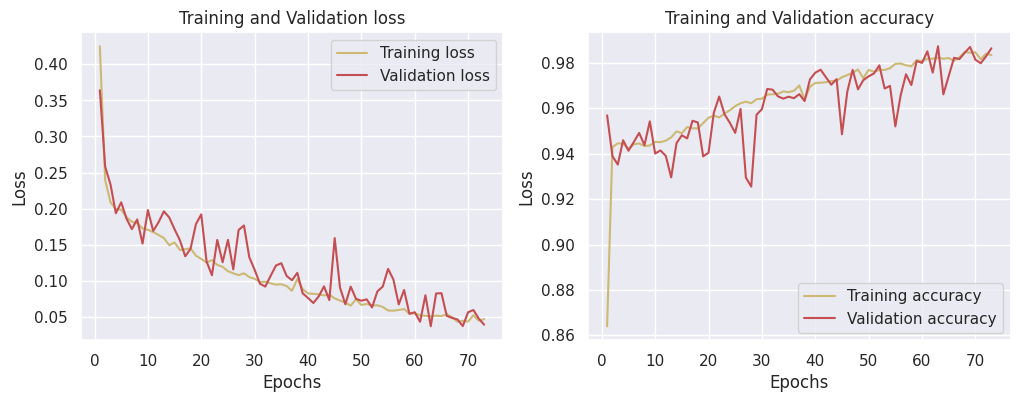

In [49]:
# plot the training and validation accuracy and loss at each epoch

_, axs = plt.subplots(1, 2, figsize=(12, 4))


for ax, metric in zip(axs, results.keys()):
    epochs = range(1, len(results[metric]["train"]) + 1)
    ax.plot(epochs, results[metric]["train"], 'y', label=f'Training {metric}')
    ax.plot(epochs, results[metric]["val"], 'r', label=f'Validation {metric}')

    ax.legend()
    ax.set_title(f'Training and Validation {metric}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

plt.show()